In [1]:
# (Uncomment if you need to install)

import os
import random
import numpy as np
import pygame
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count


pygame 2.6.1 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [21]:
class SnakeEnv:
    def __init__(self, width=10, height=10, block_size=20):
        pygame.init()
        self.width, self.height, self.block = width, height, block_size
        # use self.block, not block
        self.display = pygame.Surface((self.width * self.block,
                                       self.height * self.block))
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.direction = (1, 0)
        self.snake = [(self.width//2, self.height//2)]
        self._place_food()
        self.done, self.score = False, 0
        return self._get_obs()


    def _place_food(self):
        while True:
            self.food = (random.randrange(self.width),
                         random.randrange(self.height))
            if self.food not in self.snake:
                break

    def _get_obs(self):
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        food_x, food_y = self.food

        # Danger detection: front, right, left
        def danger_at(offset):
            dx, dy = offset
            new_x, new_y = head_x + dx, head_y + dy
            return int(
                new_x < 0 or new_x >= self.width or
                new_y < 0 or new_y >= self.height or
                (new_x, new_y) in self.snake
            )

        left  = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        danger = [
            danger_at(front),
            danger_at(right),
            danger_at(left)
        ]

        # Food direction (relative)
        food_dx = int(np.sign(food_x - head_x))
        food_dy = int(np.sign(food_y - head_y))

        # Normalize direction
        dir_features = [
            int(dir_x == 1), int(dir_x == -1),
            int(dir_y == 1), int(dir_y == -1)
        ]

        return np.array(danger + dir_features + [food_dx, food_dy], dtype=np.float32)



    def step(self, action):
        dirs = [(-1,0),(0,1),(1,0),(0,-1)]
        new_dir = dirs[action]
        if (new_dir[0]==-self.direction[0] and
            new_dir[1]==-self.direction[1]):
            new_dir = self.direction
        self.direction = new_dir

        head = (self.snake[0][0]+new_dir[0],
                self.snake[0][1]+new_dir[1])
        if (not 0<=head[0]<self.width or
            not 0<=head[1]<self.height or
            head in self.snake):
            self.done = True
            return self._get_obs(), -10, True, {}

        self.snake.insert(0, head)
        if head == self.food:
            reward, self.score = 10, self.score+1
            self._place_food()
        else:
            reward = -0.1
            self.snake.pop()

        return self._get_obs(), reward, False, {}

    # Inside your SnakeEnv class, overwrite render() with:

    def render(self):
        """
        Return a (H_px, W_px, 3) uint8 image of the game:
         - snake in green, food in red, background black.
        """
        H_px = self.height * self.block
        W_px = self.width  * self.block
        frame = np.zeros((H_px, W_px, 3), dtype=np.uint8)

        # Draw snake
        for x, y in self.snake:
            y0, y1 = y*self.block, (y+1)*self.block
            x0, x1 = x*self.block, (x+1)*self.block
            frame[y0:y1, x0:x1] = np.array([0,255,0], dtype=np.uint8)

        # Draw food
        fx, fy = self.food
        y0, y1 = fy*self.block, (fy+1)*self.block
        x0, x1 = fx*self.block, (fx+1)*self.block
        frame[y0:y1, x0:x1] = np.array([255,0,0], dtype=np.uint8)

        return frame


In [5]:
from collections import deque, namedtuple

env = SnakeEnv()


# Define a transition tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Instantiate and test
memory = ReplayMemory(capacity=1000)

# Push a dummy transition
dummy_state  = env.reset()
dummy_action = 0
dummy_reward = 1.0
dummy_next   = dummy_state
dummy_done   = False
memory.push(dummy_state, dummy_action, dummy_reward, dummy_next, dummy_done)

# Sample should return a list of length 1
batch = memory.sample(1)
print("Sampled batch:", batch)
print("Buffer length:", len(memory))


Sampled batch: [Transition(state=array([ 0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  1.], dtype=float32), action=0, reward=1.0, next_state=array([ 0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  1.], dtype=float32), done=False)]
Buffer length: 1


In [6]:
# Cell 7 – DQN Network Definition

import torch.nn as nn

state_dim  = len(env.reset()) # flattened grid size
action_dim = 4                         # up, right, down, left

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
# Initialize target to match policy
target_net.load_state_dict(policy_net.state_dict())


<All keys matched successfully>

In [7]:
# Cell 8 – Action Selection, Optimizer, and DQN Update

import torch.optim as optim
import torch.nn.functional as F

# ε‑greedy action selection
def select_action(state, eps):
    """
    state: 1D numpy array of length state_dim
    eps: float between 0 and 1
    returns: int action in [0, action_dim)
    """
    if random.random() < eps:
        return random.randrange(action_dim)
    # otherwise pick best Q-value action
    state_v = torch.from_numpy(state).unsqueeze(0).to(device)   # shape [1, state_dim]
    with torch.no_grad():
        q_vals = policy_net(state_v)                            # shape [1, action_dim]
    return int(q_vals.argmax(dim=1).item())

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Single DQN update step
def optimize_dqn(batch_size, gamma):
    if len(memory) < batch_size:
        return

    # Sample a batch
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Convert to tensors
    states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)
    actions     = torch.tensor(batch.action,     dtype=torch.int64,   device=device).unsqueeze(1)
    rewards     = torch.tensor(batch.reward,     dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
    dones       = torch.tensor(batch.done,       dtype=torch.float32, device=device).unsqueeze(1)

    # Current Q values
    q_values = policy_net(states).gather(1, actions)   # shape [batch_size, 1]

    # Next state values from target network
    next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q = rewards + gamma * next_q * (1.0 - dones)

    # Compute loss and backprop
    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [8]:
# Cell 9 – Hyperparameters & Checkpoints

# RL hyperparameters
config = {
    "gamma":           0.99,    # discount factor
    "batch_size":      64,      # replay batch size
    "eps_start":       1.0,     # initial ε for ε‑greedy
    "eps_end":         0.01,    # final ε
    "eps_decay":       5000,    # decay rate for ε
    "target_update":   10,      # episodes between target network sync
    "num_episodes":    1000      # total training episodes
}

# Checkpoint directory and file
ckpt_dir  = "checkpoints"
ckpt_path = os.path.join(ckpt_dir, "dqn_snake.pth")
os.makedirs(ckpt_dir, exist_ok=True)

print("Config:", config)
print("Checkpoint will be saved to:", ckpt_path)


Config: {'gamma': 0.99, 'batch_size': 64, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 5000, 'target_update': 10, 'num_episodes': 1000}
Checkpoint will be saved to: checkpoints/dqn_snake.pth


In [9]:
# Cell 10 – Checkpoint Save & Load

def save_checkpoint():
    """Save policy network and optimizer states."""
    torch.save({
        "policy_state_dict": policy_net.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, ckpt_path)
    print(f"Checkpoint saved to {ckpt_path}")

def load_checkpoint():
    """Load policy network and optimizer states if available."""
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=device)
        policy_net.load_state_dict(checkpoint["policy_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Loaded checkpoint from {ckpt_path}")
    else:
        print("No checkpoint found, starting from scratch.")



In [10]:
# Cell 11 – Training Loop (test run for a few episodes)

episode_rewards = []
steps_done = 0

def get_epsilon(step):
    """Exponential decay from eps_start to eps_end."""
    return config["eps_end"] + (config["eps_start"] - config["eps_end"]) * \
           np.exp(-1. * step / config["eps_decay"])

# Run a brief training to check integration
for ep in range(1, 21):  # just 20 episodes for a quick test
    state = env.reset()
    total_reward = 0
    
    while True:
        eps = get_epsilon(steps_done)
        action = select_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        
        # Store transition and learn
        memory.push(state, action, reward, next_state, done)
        optimize_dqn(config["batch_size"], config["gamma"])
        
        state = next_state
        total_reward += reward
        steps_done += 1
        
        if done:
            break

    episode_rewards.append(total_reward)
    
    # Periodically update target network
    if ep % config["target_update"] == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # Print progress
    print(f"Episode {ep:2d} | Reward: {total_reward}")

# Save final checkpoint
save_checkpoint()


Episode  1 | Reward: -11.1
Episode  2 | Reward: -11.1
Episode  3 | Reward: -12.4
Episode  4 | Reward: -12.4
Episode  5 | Reward: -11.0
Episode  6 | Reward: -11.1
Episode  7 | Reward: -10.4
Episode  8 | Reward: -11.8
Episode  9 | Reward: -0.7999999999999989
Episode 10 | Reward: -10.8
Episode 11 | Reward: -12.600000000000001


/var/folders/5t/35w5sh2n3r196t69kjv4ldm00000gn/T/ipykernel_30569/364825624.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)


Episode 12 | Reward: -10.7
Episode 13 | Reward: -11.0
Episode 14 | Reward: -12.8
Episode 15 | Reward: -11.700000000000001
Episode 16 | Reward: -12.200000000000001
Episode 17 | Reward: -10.9
Episode 18 | Reward: -0.7999999999999972
Episode 19 | Reward: -11.2
Episode 20 | Reward: -11.4
Checkpoint saved to checkpoints/dqn_snake.pth


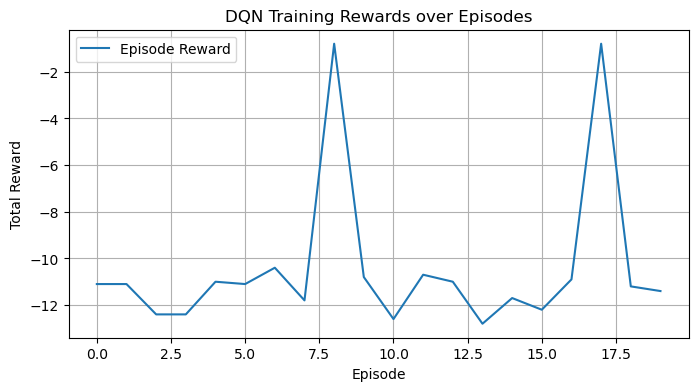

In [11]:
# Cell 12 – Training Rewards Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN Training Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#Cell 13

def evaluate_policy(net, env, n_episodes=10, max_steps=500):
    net.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            steps = 0
            while not done and steps < max_steps:
                state_v = torch.from_numpy(state).float().unsqueeze(0).to(device)
                probs, _ = net(state_v)
                action = probs.argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
                steps += 1
            scores.append(total)
    net.train()
    return scores


# Run evaluation with fresh env
eval_env = SnakeEnv()
eval_scores = evaluate_policy(model, eval_env, n_episodes=20)
print(f"Eval (20 eps): avg={np.mean(eval_scores):.2f} ± {np.std(eval_scores):.2f}")


ValueError: not enough values to unpack (expected 2, got 1)

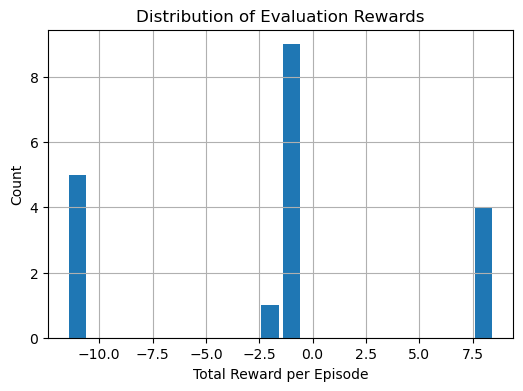

In [13]:
#Cell 14

plt.figure(figsize=(6, 4))
plt.hist(eval_scores, bins=range(int(min(eval_scores)), int(max(eval_scores)) + 2),
         align='left', rwidth=0.8)
plt.title("Distribution of Evaluation Rewards")
plt.xlabel("Total Reward per Episode")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [14]:
# Cell 15
# load_checkpoint()

episode_rewards = []
steps_done = 0
env = SnakeEnv()  # re-init env to ensure fresh instance

max_steps = 500  # limit per episode

for ep in range(1, config["num_episodes"] + 1):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps):
        eps = get_epsilon(steps_done)
        action = select_action(state, eps)
        next_state, reward, done, _ = env.step(action)

        memory.push(state, action, reward, next_state, done)
        optimize_dqn(config["batch_size"], config["gamma"])

        state = next_state
        total_reward += reward
        steps_done += 1

        if done:
            break

    episode_rewards.append(total_reward)

    if ep % config["target_update"] == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if ep % 50 == 0:
        avg = np.mean(episode_rewards[-50:])
        print(f"Episode {ep:3d} | Last Reward: {total_reward:6.2f} | Avg(50): {avg:.2f}")

save_checkpoint()


Episode  50 | Last Reward:  -0.40 | Avg(50): -9.32
Episode 100 | Last Reward: -13.10 | Avg(50): -8.06
Episode 150 | Last Reward:  24.10 | Avg(50): 1.87
Episode 200 | Last Reward: -10.80 | Avg(50): 7.62
Episode 250 | Last Reward:  15.70 | Avg(50): 16.14
Episode 300 | Last Reward:  -1.10 | Avg(50): 35.51
Episode 350 | Last Reward:  90.60 | Avg(50): 52.42
Episode 400 | Last Reward:  18.50 | Avg(50): 87.78
Episode 450 | Last Reward: 119.00 | Avg(50): 115.95
Episode 500 | Last Reward:  74.00 | Avg(50): 110.81
Episode 550 | Last Reward:  41.00 | Avg(50): 141.96
Episode 600 | Last Reward:  46.10 | Avg(50): 130.81
Episode 650 | Last Reward: 146.10 | Avg(50): 132.04
Episode 700 | Last Reward: 152.20 | Avg(50): 133.03
Episode 750 | Last Reward: 171.20 | Avg(50): 138.38
Episode 800 | Last Reward: 231.90 | Avg(50): 148.77
Episode 850 | Last Reward: 207.80 | Avg(50): 129.87
Episode 900 | Last Reward:  54.10 | Avg(50): 116.64
Episode 950 | Last Reward: 136.60 | Avg(50): 135.63
Episode 1000 | Last Re

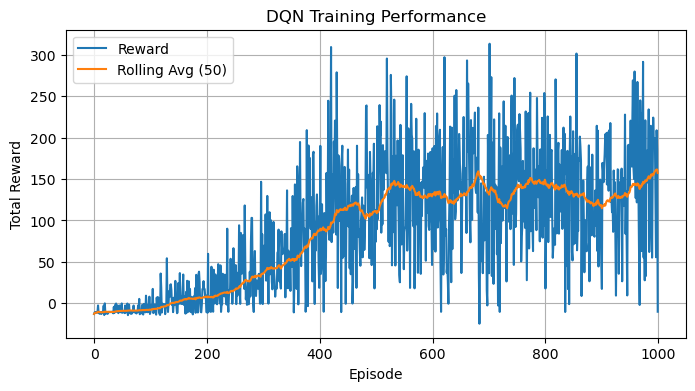

In [15]:
# Cell 16
## Rolling Average Reward (Visualization)
import matplotlib.pyplot as plt

window = 50
rolling_avg = [np.mean(episode_rewards[max(0, i - window):i+1]) for i in range(len(episode_rewards))]

plt.figure(figsize=(8, 4))
plt.plot(episode_rewards, label="Reward")
plt.plot(rolling_avg, label=f"Rolling Avg ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

In [24]:
class RolloutBuffer:
    def __init__(self):
        self.states     = []
        self.actions    = []
        self.log_probs  = []
        self.rewards    = []
        self.dones      = []
        self.values     = []

    def clear(self):
        self.__init__()


In [25]:
ppo_config = {
    "gamma":        0.99,
    "gae_lambda":   0.95,
    "clip_eps":     0.2,
    "lr":           2.5e-4,
    "epochs":       4,
    "batch_size":   64,
    "update_steps": 2048
}

def compute_gae(rewards, values, dones, gamma, lam):
    advantages = []
    gae = 0
    values = values + [0]  # bootstrap
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return advantages


In [26]:
def collect_trajectory(env, model, buffer, steps, max_steps=500):
    state = env.reset()
    for _ in range(steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, done, _ = env.step(action.item())

        buffer.states.append(state)
        buffer.actions.append(action.item())
        buffer.log_probs.append(dist.log_prob(action).item())
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.item())

        state = next_state
        if done:
            state = env.reset()


In [27]:
def ppo_update(model, optimizer, buffer, config):
    # Convert to tensors
    states = torch.tensor(buffer.states, dtype=torch.float32).to(device)
    actions = torch.tensor(buffer.actions).to(device)
    old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
    rewards = buffer.rewards
    dones = buffer.dones
    values = buffer.values

    # Compute advantages and returns
    advantages = compute_gae(rewards, values, dones,
                             config["gamma"], config["gae_lambda"])
    returns = torch.tensor([a + v for a, v in zip(advantages, values)],
                           dtype=torch.float32).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # PPO update over multiple epochs
    for _ in range(config["epochs"]):
        for i in range(0, len(states), config["batch_size"]):
            s_batch = states[i:i+config["batch_size"]]
            a_batch = actions[i:i+config["batch_size"]]
            r_batch = returns[i:i+config["batch_size"]]
            adv_batch = advantages[i:i+config["batch_size"]]
            logp_old_batch = old_log_probs[i:i+config["batch_size"]]

            probs, values = model(s_batch)
            dist = torch.distributions.Categorical(probs)
            logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logp - logp_old_batch)
            clipped = torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"]) * adv_batch
            loss_clip = -torch.min(ratio * adv_batch, clipped).mean()
            loss_value = F.mse_loss(values.squeeze(), r_batch)
            loss = loss_clip + 0.5 * loss_value - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [28]:
env = SnakeEnv()
buffer = RolloutBuffer()
model = ActorCritic(state_dim=len(env.reset()), action_dim=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=ppo_config["lr"])

reward_history = []

for update in range(1, 101):  # 100 updates
    collect_trajectory(env, model, buffer, ppo_config["update_steps"])
    ppo_update(model, optimizer, buffer, ppo_config)
    buffer.clear()

    # Evaluate average reward over 10 episodes
    eval_scores = evaluate_policy(model, env, n_episodes=10)
    avg_reward = np.mean(eval_scores)
    reward_history.append(avg_reward)
    print(f"Update {update:3d} | Avg Reward: {avg_reward:.2f}")


AttributeError: 'tuple' object has no attribute 'argmax'